In [1]:
import pandas as pd
from sklearn.datasets import make_regression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import geopy.distance
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import *

In [2]:
train_file = 'data/out/train_cleaned.csv'
test_file = 'data/out/test_cleaned.csv'

In [3]:
train_data = pd.read_csv(train_file)
train_data.drop(columns=['Unnamed: 0'],axis=1,inplace=True)
test_data = pd.read_csv(test_file)
test_data.drop(columns=['Unnamed: 0'],axis=1,inplace=True)

In [4]:
train_data.head()

,id,fecha,latitud_origen,longitud_origen,latitud_destino,longitud_destino,distancia,tiempo,distancia_api,tiempo_api,...,region_destino_Lima,region_destino_Loreto,region_destino_Madre de Dios,region_destino_Moquegua,region_destino_Pasco,region_destino_Puno,region_destino_San Martín,region_destino_Tacna,region_destino_Tumbes,region_destino_Ucayali
0,124092420,2021-07-28,-11.965070,-77.12269,-12.07020,-77.13524,14747.0,1775.0,13573.1,1285.1,...,1,0,0,0,0,0,0,0,0,0
1,124091219,2021-07-25,-12.155090,-76.97996,-12.07570,-76.91754,17171.0,1821.0,14549.1,1210.1,...,1,0,0,0,0,0,0,0,0,0
2,124091187,2021-07-25,-14.533770,-75.18460,-14.88630,-74.99414,58708.0,3842.0,58253.0,3680.0,...,0,0,0,0,0,0,0,0,0,0
3,124093495,2021-08-01,-5.201517,-80.64635,-5.38453,-80.62314,23611.0,1446.0,23597.4,1472.8,...,0,0,0,0,0,0,0,0,0,0
4,124092156,2021-07-27,-11.967470,-77.12508,-12.03500,-77.07444,14229.0,1974.0,14608.3,1154.8,...,1,0,0,0,0,0,0,0,0,0


In [5]:
test_data.head()

,id,fecha,latitud_origen,longitud_origen,latitud_destino,longitud_destino,distancia_api,tiempo_api,region_origen_Amazonas,region_origen_Ancash,...,region_destino_Lima,region_destino_Loreto,region_destino_Madre de Dios,region_destino_Moquegua,region_destino_Pasco,region_destino_Puno,region_destino_San Martín,region_destino_Tacna,region_destino_Tumbes,region_destino_Ucayali
0,124089165,2021-07-20,-12.781050,-74.99228,-12.76703,-74.64612,76381.7,4891.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,124093149,2021-07-31,-7.140513,-78.51395,-7.58284,-78.07524,124606.8,10232.9,0,0,...,0,0,0,0,0,0,0,0,0,0
2,124090750,2021-07-24,-12.010250,-77.11206,-11.99380,-77.02614,20630.3,1631.7,0,0,...,1,0,0,0,0,0,0,0,0,0
3,124092491,2021-07-29,-12.155750,-76.97977,-12.22090,-76.91364,12105.8,1067.6,0,0,...,1,0,0,0,0,0,0,0,0,0
4,124091871,2021-07-27,-12.114920,-77.04678,-12.07910,-77.11724,9403.2,652.5,0,0,...,1,0,0,0,0,0,0,0,0,0


In [6]:
train_data.shape

(1952, 59)

In [7]:
test_data.shape

(852, 57)

In [8]:
X=train_data.loc[:,train_data.columns.isin(['id','fecha','distancia','tiempo']) == False].values
y=train_data.iloc[:,6:8].values
yhat=test_data.iloc[:,2:].values

In [9]:
from sklearn import preprocessing
preprocessing.minmax_scale(X)
preprocessing.minmax_scale(yhat)

array([[0.36037929, 0.52007466, 0.36614227, ..., 0.        , 0.        ,
        0.        ],
       [0.74842017, 0.22806174, 0.72358461, ..., 0.        , 0.        ,
        0.        ],
       [0.4134065 , 0.34430488, 0.41945535, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.40340095, 0.3552709 , 0.41559216, ..., 0.        , 0.        ,
        0.        ],
       [0.40340026, 0.3552709 , 0.42098601, ..., 0.        , 0.        ,
        0.        ],
       [0.15010318, 0.93230005, 0.23882396, ..., 0.        , 0.        ,
        0.        ]])

In [10]:
from keras.optimizers import Adam
from keras.layers import LeakyReLU

def get_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(256, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(128, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(64, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(32, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(16, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(8, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(4, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    model.compile(loss='mape', optimizer=Adam(learning_rate=1e-3))
    return model

In [11]:
n_inputs, n_outputs = X.shape[1], y.shape[1]
print(X.shape[1], y.shape[1])

55 2


In [12]:
from keras.callbacks import ModelCheckpoint

def get_callbacks():
    filepath = 'data/out/try7.h5'
    callback1 = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
    callback2 = CSVLogger('data/out/try7.csv')
    
    return [callback1,callback2]

In [13]:
model = get_model(n_inputs, n_outputs)
history = model.fit(X, y, verbose=1, epochs=400, validation_split=0.2, callbacks=get_callbacks())

Epoch 1/400
49/49 [==============================] - 2s 20ms/step - loss: 81.1287 - val_loss: 53.7008

Epoch 00001: loss improved from inf to 70.24044, saving model to data/out\try7.h5
Epoch 2/400
49/49 [==============================] - 0s 2ms/step - loss: 40.6589 - val_loss: 16.9229

Epoch 00002: loss improved from 70.24044 to 30.37894, saving model to data/out\try7.h5
Epoch 3/400
49/49 [==============================] - 0s 2ms/step - loss: 17.7047 - val_loss: 15.2743

Epoch 00003: loss improved from 30.37894 to 17.43087, saving model to data/out\try7.h5
Epoch 4/400
49/49 [==============================] - 0s 2ms/step - loss: 15.9285 - val_loss: 15.0439

Epoch 00004: loss improved from 17.43087 to 15.98711, saving model to data/out\try7.h5
Epoch 5/400
49/49 [==============================] - 0s 2ms/step - loss: 16.4858 - val_loss: 22.1328

Epoch 00005: loss did not improve from 15.98711
Epoch 6/400
49/49 [==============================] - 0s 2ms/step - loss: 16.0769 - val_loss: 15.41

49/49 [==============================] - 0s 2ms/step - loss: 14.6043 - val_loss: 15.5107

Epoch 00051: loss did not improve from 12.20847
Epoch 52/400
49/49 [==============================] - 0s 2ms/step - loss: 12.8591 - val_loss: 13.3578

Epoch 00052: loss did not improve from 12.20847
Epoch 53/400
49/49 [==============================] - 0s 2ms/step - loss: 12.5435 - val_loss: 13.1218

Epoch 00053: loss did not improve from 12.20847
Epoch 54/400
49/49 [==============================] - 0s 2ms/step - loss: 12.0215 - val_loss: 12.9345

Epoch 00054: loss did not improve from 12.20847
Epoch 55/400
49/49 [==============================] - 0s 2ms/step - loss: 12.2748 - val_loss: 12.9561

Epoch 00055: loss improved from 12.20847 to 12.05985, saving model to data/out\try7.h5
Epoch 56/400
49/49 [==============================] - 0s 2ms/step - loss: 12.4936 - val_loss: 12.9772

Epoch 00056: loss did not improve from 12.05985
Epoch 57/400
49/49 [==============================] - 0s 2ms/step - 

49/49 [==============================] - 0s 2ms/step - loss: 12.2926 - val_loss: 12.6725

Epoch 00104: loss did not improve from 11.70729
Epoch 105/400
49/49 [==============================] - 0s 3ms/step - loss: 11.4975 - val_loss: 12.6501

Epoch 00105: loss did not improve from 11.70729
Epoch 106/400
49/49 [==============================] - 0s 2ms/step - loss: 12.2131 - val_loss: 12.8946

Epoch 00106: loss did not improve from 11.70729
Epoch 107/400
49/49 [==============================] - 0s 2ms/step - loss: 12.0278 - val_loss: 12.6595

Epoch 00107: loss did not improve from 11.70729
Epoch 108/400
49/49 [==============================] - 0s 2ms/step - loss: 11.4602 - val_loss: 12.4424

Epoch 00108: loss did not improve from 11.70729
Epoch 109/400
49/49 [==============================] - 0s 2ms/step - loss: 12.1324 - val_loss: 14.1734

Epoch 00109: loss did not improve from 11.70729
Epoch 110/400
49/49 [==============================] - 0s 2ms/step - loss: 11.9611 - val_loss: 12.4341

49/49 [==============================] - 0s 2ms/step - loss: 11.9062 - val_loss: 13.8142

Epoch 00157: loss did not improve from 11.56378
Epoch 158/400
49/49 [==============================] - 0s 2ms/step - loss: 12.6559 - val_loss: 13.3022

Epoch 00158: loss did not improve from 11.56378
Epoch 159/400
49/49 [==============================] - 0s 2ms/step - loss: 12.6391 - val_loss: 12.6702

Epoch 00159: loss did not improve from 11.56378
Epoch 160/400
49/49 [==============================] - 0s 2ms/step - loss: 11.8791 - val_loss: 12.1981

Epoch 00160: loss did not improve from 11.56378
Epoch 161/400
49/49 [==============================] - 0s 2ms/step - loss: 11.4446 - val_loss: 12.4320

Epoch 00161: loss did not improve from 11.56378
Epoch 162/400
49/49 [==============================] - 0s 2ms/step - loss: 11.5163 - val_loss: 12.3792

Epoch 00162: loss did not improve from 11.56378
Epoch 163/400
49/49 [==============================] - 0s 2ms/step - loss: 11.6558 - val_loss: 12.1821

49/49 [==============================] - 0s 2ms/step - loss: 12.4437 - val_loss: 12.1961

Epoch 00210: loss did not improve from 11.37805
Epoch 211/400
49/49 [==============================] - 0s 2ms/step - loss: 11.4032 - val_loss: 12.0813

Epoch 00211: loss did not improve from 11.37805
Epoch 212/400
49/49 [==============================] - 0s 2ms/step - loss: 11.4015 - val_loss: 12.1474

Epoch 00212: loss did not improve from 11.37805
Epoch 213/400
49/49 [==============================] - 0s 2ms/step - loss: 11.5157 - val_loss: 12.0952

Epoch 00213: loss did not improve from 11.37805
Epoch 214/400
49/49 [==============================] - 0s 2ms/step - loss: 11.2281 - val_loss: 12.8974

Epoch 00214: loss did not improve from 11.37805
Epoch 215/400
49/49 [==============================] - 0s 2ms/step - loss: 11.5009 - val_loss: 12.4778

Epoch 00215: loss did not improve from 11.37805
Epoch 216/400
49/49 [==============================] - 0s 2ms/step - loss: 11.4287 - val_loss: 12.2718

49/49 [==============================] - 0s 2ms/step - loss: 11.2456 - val_loss: 11.8901

Epoch 00263: loss did not improve from 11.20371
Epoch 264/400
49/49 [==============================] - 0s 2ms/step - loss: 11.1239 - val_loss: 12.6105

Epoch 00264: loss did not improve from 11.20371
Epoch 265/400
49/49 [==============================] - 0s 2ms/step - loss: 11.7667 - val_loss: 11.8298

Epoch 00265: loss did not improve from 11.20371
Epoch 266/400
49/49 [==============================] - 0s 2ms/step - loss: 11.1217 - val_loss: 11.8980

Epoch 00266: loss did not improve from 11.20371
Epoch 267/400
49/49 [==============================] - 0s 2ms/step - loss: 11.4241 - val_loss: 11.8666

Epoch 00267: loss did not improve from 11.20371
Epoch 268/400
49/49 [==============================] - 0s 2ms/step - loss: 11.8125 - val_loss: 12.1952

Epoch 00268: loss did not improve from 11.20371
Epoch 269/400
49/49 [==============================] - 0s 2ms/step - loss: 11.3070 - val_loss: 12.7656

49/49 [==============================] - 0s 2ms/step - loss: 11.2950 - val_loss: 11.7670

Epoch 00316: loss did not improve from 10.97234
Epoch 317/400
49/49 [==============================] - 0s 2ms/step - loss: 11.5123 - val_loss: 11.5635

Epoch 00317: loss did not improve from 10.97234
Epoch 318/400
49/49 [==============================] - 0s 2ms/step - loss: 11.8420 - val_loss: 11.9067

Epoch 00318: loss did not improve from 10.97234
Epoch 319/400
49/49 [==============================] - 0s 2ms/step - loss: 11.3713 - val_loss: 11.7025

Epoch 00319: loss did not improve from 10.97234
Epoch 320/400
49/49 [==============================] - 0s 2ms/step - loss: 11.1868 - val_loss: 11.6847

Epoch 00320: loss did not improve from 10.97234
Epoch 321/400
49/49 [==============================] - 0s 2ms/step - loss: 11.3869 - val_loss: 11.8953

Epoch 00321: loss did not improve from 10.97234
Epoch 322/400
49/49 [==============================] - 0s 2ms/step - loss: 10.9888 - val_loss: 12.0782

49/49 [==============================] - 0s 2ms/step - loss: 10.7523 - val_loss: 11.5525

Epoch 00370: loss did not improve from 10.97234
Epoch 371/400
49/49 [==============================] - 0s 2ms/step - loss: 11.1289 - val_loss: 12.4840

Epoch 00371: loss did not improve from 10.97234
Epoch 372/400
49/49 [==============================] - 0s 2ms/step - loss: 11.5255 - val_loss: 11.7159

Epoch 00372: loss did not improve from 10.97234
Epoch 373/400
49/49 [==============================] - 0s 2ms/step - loss: 11.2713 - val_loss: 11.6157

Epoch 00373: loss did not improve from 10.97234
Epoch 374/400
49/49 [==============================] - 0s 2ms/step - loss: 11.6699 - val_loss: 11.6085

Epoch 00374: loss did not improve from 10.97234
Epoch 375/400
49/49 [==============================] - 0s 2ms/step - loss: 11.3580 - val_loss: 11.8793

Epoch 00375: loss did not improve from 10.97234
Epoch 376/400
49/49 [==============================] - 0s 2ms/step - loss: 11.4069 - val_loss: 11.5469

In [14]:
#Cargando el mejor modelo

from keras.models import load_model
best_model_tf = load_model('data/out/try7.h5')

ypred = best_model_tf.predict(yhat)

In [15]:
print(ypred)

[[ 75765.2      4822.223 ]
 [125482.49    10604.442 ]
 [ 21199.916    2416.1638]
 ...
 [ 24820.64     2671.1685]
 [ 91509.375    7238.5317]
 [166110.48     9695.005 ]]


In [16]:
best_model_tf.evaluate(X,y)

61/61 [==============================] - 0s 600us/step - loss: 11.1124


11.112381935119629

In [17]:
ids = pd.read_csv(test_file)
ids_1 = ids['id']

In [18]:
df = pd.DataFrame()
df['ID'] = ids_1
df['DISTANCIA'] = ypred[:,0]
df['TIEMPO'] = ypred[:,1]
print(df)

            ID      DISTANCIA        TIEMPO
0    124089165   75765.203125   4822.223145
1    124093149  125482.492188  10604.442383
2    124090750   21199.916016   2416.163818
3    124092491   12662.423828   1622.004150
4    124091871    9355.529297    886.077942
..         ...            ...           ...
847  124088805   15707.215820   2054.603760
848  124089757   12162.489258   1406.649658
849  124089569   24820.640625   2671.168457
850  124092518   91509.375000   7238.531738
851  124090644  166110.484375   9695.004883

[852 rows x 3 columns]


In [19]:
df.to_csv('data/out/try7_out.csv',index=False)

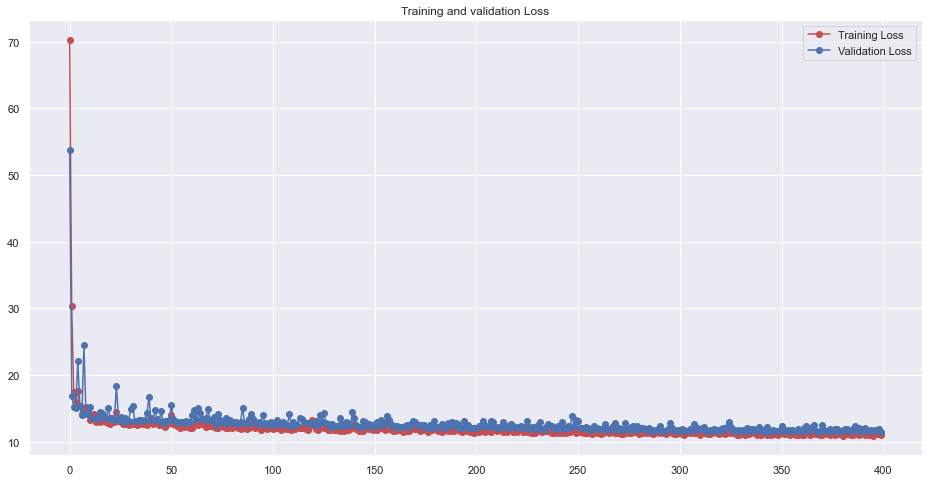

<Figure size 432x288 with 0 Axes>

In [20]:
#Graficar Epochs

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(0,len(loss))
fig = plt.gcf()
fig.set_size_inches(16, 8)

fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.plot(epochs, loss, 'r', label='Training Loss',marker = "o")
plt.plot(epochs, val_loss, 'b', label='Validation Loss',marker = "o")
plt.title('Training and validation Loss')
plt.legend(loc=0)
#plt.savefig('Multiclass Model .png')
plt.figure()
plt.show()